## Import dependencies

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np
from scipy.fftpack import dct
import numpy as np
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from transformers import DistilBertTokenizer, TFDistilBertModel

## Dataloader

In [19]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/train_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/train_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/test_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=False,
                                                   batch_size = 64)

Found 36411 images belonging to 7 classes.
Found 15601 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [20]:
print(train_dataset.class_indices)
print(validation_dataset.class_indices)
print(test_dataset.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Metrics

In [21]:
def f1_score(y_true, y_pred):
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

## Model

#### CBAM

In [22]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape
    ## Shared layers
    l1 = K.layers.Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = K.layers.Dense(channel, use_bias=False)
    ## Global Average Pooling
    x1 = K.layers.GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)
    ## Global Max Pooling
    x2 = K.layers.GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)
    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = K.layers.Activation("sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)
    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)
    ## Concatenat both the features
    feats = K.layers.Concatenate()([x1, x2])
    ## Conv layer
    feats = K.layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

#### Deep Learner

In [23]:
input_layer = K.Input(shape=(160,160,3))
deep_learner = K.applications.ResNet50(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in deep_learner.layers:
    layer.trainable = True
for i, layer in enumerate(deep_learner.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_5 - True
1 conv1_pad - True
2 conv1_conv - True
3 conv1_bn - True
4 conv1_relu - True
5 pool1_pad - True
6 pool1_pool - True
7 conv2_block1_1_conv - True
8 conv2_block1_1_bn - True
9 conv2_block1_1_relu - True
10 conv2_block1_2_conv - True
11 conv2_block1_2_bn - True
12 conv2_block1_2_relu - True
13 conv2_block1_0_conv - True
14 conv2_block1_3_conv - True
15 conv2_block1_0_bn - True
16 conv2_block1_3_bn - True
17 conv2_block1_add - True
18 conv2_block1_out - True
19 conv2_block2_1_conv - True
20 conv2_block2_1_bn - True
21 conv2_block2_1_relu - True
22 conv2_block2_2_conv - True
23 conv2_block2_2_bn - True
24 conv2_block2_2_relu - True
25 conv2_block2_3_conv - True
26 conv2_block2_3_bn - True
27 conv2_block2_add - True
28 conv2_block2_out - True
29 conv2_block3_1_conv - True
30 conv2_block3_1_bn - True
31 conv2_block3_1_relu - True
32 conv2_block3_2_conv - True
33 conv2_block3_2_bn - True
34 conv2_block3_2_relu - True
35 conv2_block3_3_conv - True
36 conv2_block3_3_bn - True
37

#### Model

In [24]:
input_img = K.layers.Input(shape=(160,160,3)) 
feat_img = deep_learner(input_img)
flat = K.layers.GlobalAveragePooling2D()(feat_img)
output = K.layers.Dense(7, activation='softmax')(flat)

model = K.Model(inputs=input_img, outputs=output)
optimizer = K.optimizers.Adam(lr=0.01)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


## Training

In [25]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='ResNet50.h5',
    monitor='val_f1_score',
    save_best_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/50
569/569 [==============================] - ETA: 0s - loss: 0.7641 - accuracy: 0.7150 - precision: 0.8012 - recall: 0.6261 - auc: 0.9517 - f1_score: 0.6971
Epoch 1: val_f1_score improved from -inf to 0.02549, saving model to ResNet50.h5
569/569 [==============================] - 319s 492ms/step - loss: 0.7641 - accuracy: 0.7150 - precision: 0.8012 - recall: 0.6261 - auc: 0.9517 - f1_score: 0.6971 - val_loss: 2.4020 - val_accuracy: 0.1079 - val_precision: 0.0815 - val_recall: 0.0153 - val_auc: 0.5249 - val_f1_score: 0.0255
Epoch 2/50
569/569 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.8308 - precision: 0.8679 - recall: 0.7905 - auc: 0.9816 - f1_score: 0.8269
Epoch 2: val_f1_score improved from 0.02549 to 0.36977, saving model to ResNet50.h5
569/569 [==============================] - 286s 502ms/step - loss: 0.4558 - accuracy: 0.8308 - precision: 0.8679 - recall: 0.7905 - auc: 0.9816 - f1_score: 0.8269 - val_loss: 7.2769 - val_accuracy: 0.3769 - val_p

#### Training plots

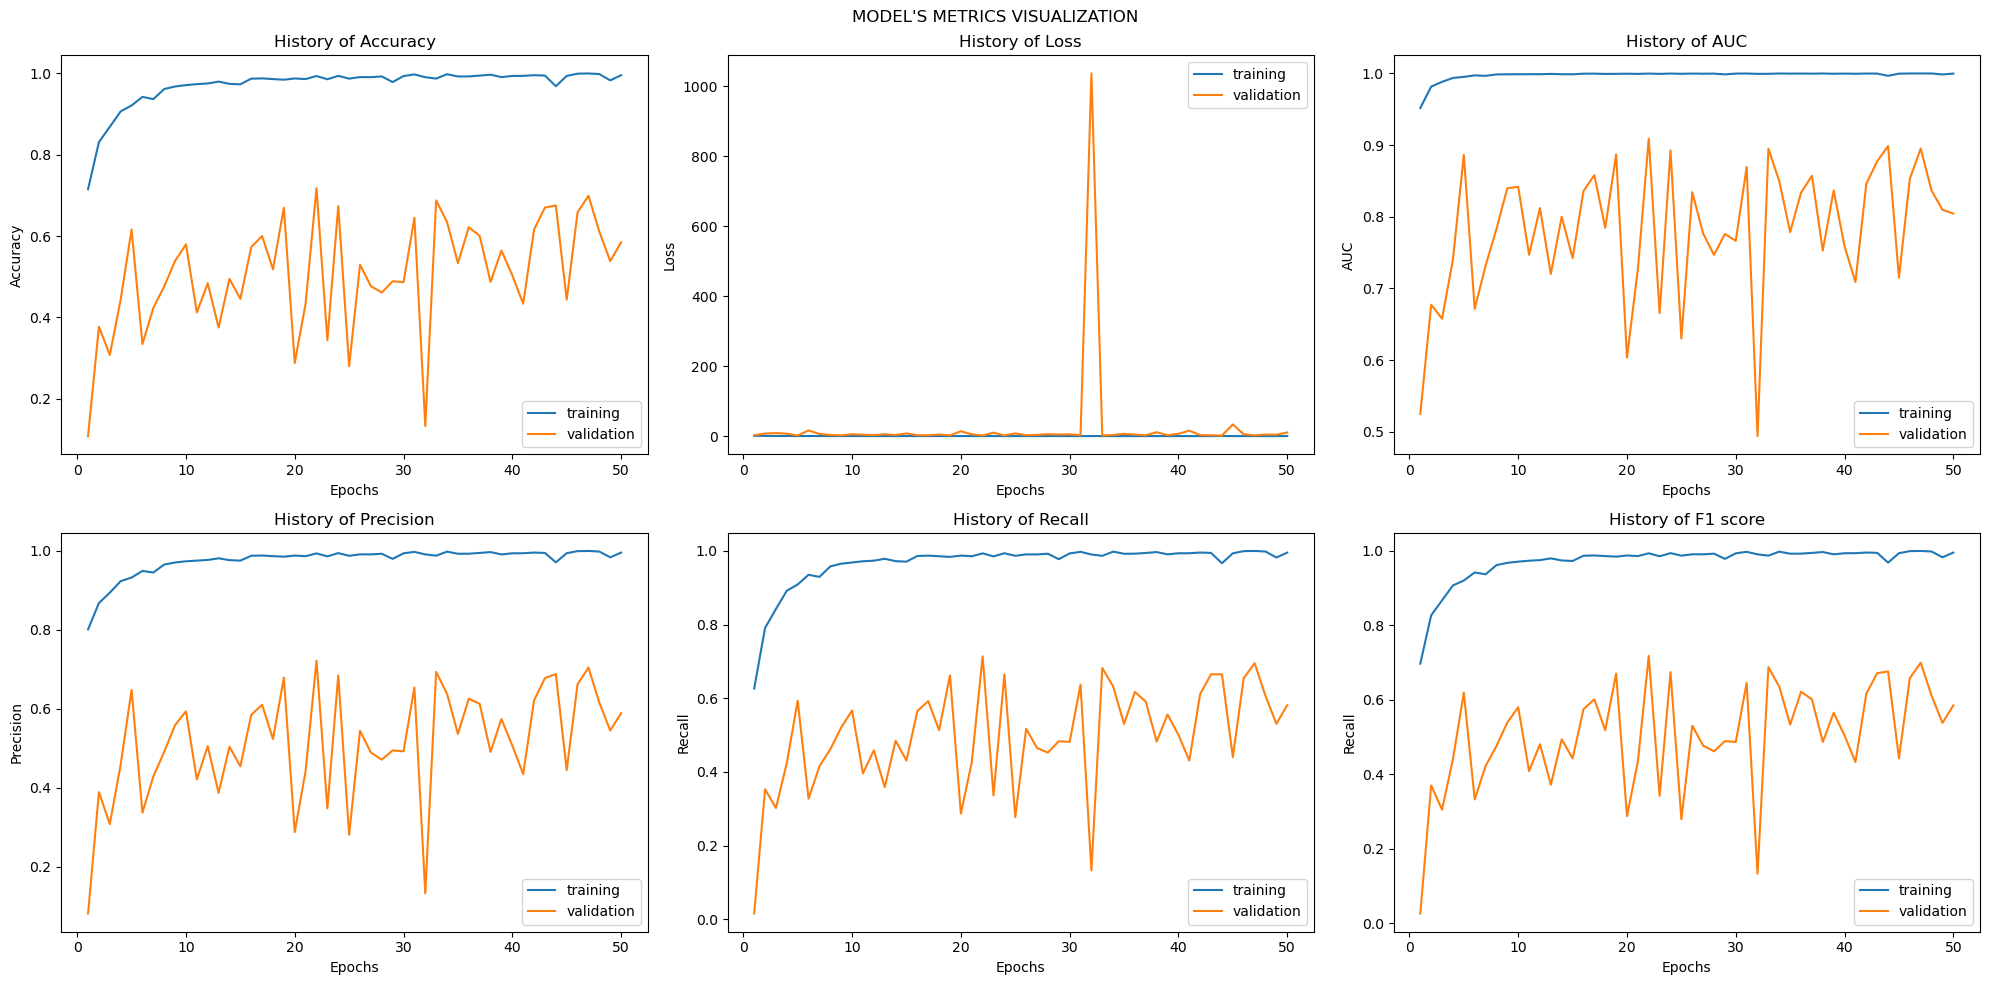

In [26]:
import matplotlib.pyplot as plt

def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    axes[0, 0].plot(range(1, len(acc) + 1), acc)
    axes[0, 0].plot(range(1, len(val_acc) + 1), val_acc)
    axes[0, 0].set_title('History of Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(['training', 'validation'])

    axes[0, 1].plot(range(1, len(loss) + 1), loss)
    axes[0, 1].plot(range(1, len(val_loss) + 1), val_loss)
    axes[0, 1].set_title('History of Loss')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(['training', 'validation'])

    axes[0, 2].plot(range(1, len(auc) + 1), auc)
    axes[0, 2].plot(range(1, len(val_auc) + 1), val_auc)
    axes[0, 2].set_title('History of AUC')
    axes[0, 2].set_xlabel('Epochs')
    axes[0, 2].set_ylabel('AUC')
    axes[0, 2].legend(['training', 'validation'])

    axes[1, 0].plot(range(1, len(precision) + 1), precision)
    axes[1, 0].plot(range(1, len(val_precision) + 1), val_precision)
    axes[1, 0].set_title('History of Precision')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend(['training', 'validation'])

    axes[1, 1].plot(range(1, len(recall) + 1), recall)
    axes[1, 1].plot(range(1, len(val_recall) + 1), val_recall)
    axes[1, 1].set_title('History of Recall')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend(['training', 'validation'])

    axes[1, 2].plot(range(1, len(f1_score) + 1), f1_score)
    axes[1, 2].plot(range(1, len(val_f1_score) + 1), val_f1_score)
    axes[1, 2].set_title('History of F1 score')
    axes[1, 2].set_xlabel('Epochs')
    axes[1, 2].set_ylabel('Recall')  # Corrected from 'Recall' to 'F1 score'
    axes[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

# Call the function with your history data
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['recall'], history.history['val_recall'],
               history.history['f1_score'], history.history['val_f1_score'])

## Testing

In [27]:
model = K.models.load_model("/kaggle/working/ResNet50.h5", custom_objects={"f1_score": f1_score})

# Evaluate the model
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Accuracy", accuracy)
print("Loss", loss)
print("Precision", precision)
print("Recall", recall)
print("AUC", auc)
print("F1-score", f1_score)

18/18 [==============================] - 8s 450ms/step - loss: 0.7806 - accuracy: 0.8568 - precision: 0.8597 - recall: 0.8558 - auc: 0.9632 - f1_score: 0.8497
Accuracy 0.8567543029785156
Loss 0.7806371450424194
Precision 0.8597449660301208
Recall 0.8558477163314819
AUC 0.9632148742675781
F1-score 0.8496873378753662


/tmp/ipykernel_28/493592024.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)


Confusion Matrix


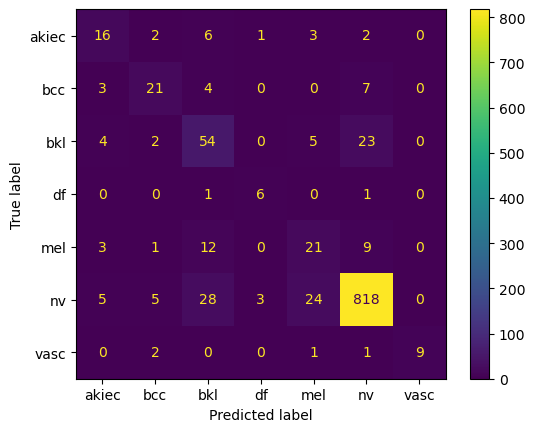

Classification Report
              precision    recall  f1-score   support

       akiec       0.52      0.53      0.52        30
         bcc       0.64      0.60      0.62        35
         bkl       0.51      0.61      0.56        88
          df       0.60      0.75      0.67         8
         mel       0.39      0.46      0.42        46
          nv       0.95      0.93      0.94       883
        vasc       1.00      0.69      0.82        13

    accuracy                           0.86      1103
   macro avg       0.66      0.65      0.65      1103
weighted avg       0.87      0.86      0.86      1103



In [28]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))